<a href="https://colab.research.google.com/github/asim5800/Deep-learning-practicals/blob/main/RNN_on_GOOGLE_STOCK_PRICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
#we train our RNN on train set only i.e. test set doesn't exist for RNN unlike CNN
#but for RNN we'll introduce that later

dataset_train = pd.read_csv('/content/drive/MyDrive/RNN/Google_Stock_Price_Train.csv')

In [73]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [53]:
dataset_train.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [54]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [55]:
#selecting the right column in which we are interested 
training_set = dataset_train.iloc[:, 1:2].values # take all rows, from index one to 2
#but recall slicing excludes last mentioned element therefore it only gives OPEN price and convert that into numpy array 
#so this still creates a dataframe but with one column   


In [56]:
len(training_set)

1258

In [57]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Feature Scaling

In [58]:
#whenever you build RNN it's recommended to use NORMALISATION instead of standardisation
#especially if there is sigmoid function as an activation function in output layer then NORM. is good practice
#so we use min max scaler for this


from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


In [59]:
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### Creating a data structure with 60 timesteps and 1 output

***60 timesteps means at each time 't' the rnn is going to look at 60 stock prices before time 't' i.e. stock prices 60 days before time 't' and based on the trends it is capturing during these 60 previous timesteps it'll try to predict the next output***
 


 ***So 60 financial days will be learned and since there are 20 financial days in one month therefore 60 timestamp will correspond to three months. That means for each day we are going to look @ three previous month to try to predict the stock price of the next day.***  

In [60]:
#so 60 timsesteps are the past information on which rnn is going to learn and predict output (stock price) @ 't+1'
# X_train willbe input to RNN
#y_train will be the output
#so for each financial day(observation) X_train will have 60 prev. stock prices before that financial day & y_train will havestock price of the next financial day
#FOR EVERY TIME t

X_train = []
y_train = []
for i in range(60, 1258):  
    X_train.append(training_set_scaled[i-60:i, 0]) #taking 60 before time t (0-59)
    y_train.append(training_set_scaled[i, 0]) # stock price at time t+1 (60th day)
X_train, y_train = np.array(X_train), np.array(y_train) #makin it in numpy array


### Reshaping

In [61]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))#MAKING 2D ARRAY INTO 3D


#1st dimension = number of stock prices
#2nd dimension = number of timesteps
#3rd dimension = number of indicators  

***Adding some more dimensionality as units that is the number of predictors we can use to predict what we want which is google stock price @t+1. So for this financial engineering problem we only have one predictor (indicators) we have only one OPEN but we'll add some more indicators to predict even better and input for RNN***

***A 3D tensor with shape [batch ( total number of obser vations we have in2012 to 2016), timesteps(60), feature(indicators  and this can be some new financial indicators that could help predict the google stock price trends say closed google stock price or even some other stock prices from other stock companies)].***
 ***We are taking ONE ONLY FOR THIS DATASET so it depends on your problem.***

***say apple & samsung highly correlated.*** 

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [63]:
regressor = Sequential() 

### Adding the first LSTM layer and some Dropout regularisation

In [64]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

#units= even though we have stacked LSTM we want our model to have high dimensionality as stock price are pretty complex task
#so we add large number of neurons    

regressor.add(Dropout(0.2))  #dropping 20% of nueron in layer will be ignored during training 50*0.2 =10 neurons will be ignored during each iteration of training

***LSTM takes three argument first the number of units number of LSTM cells (memory units) in layer, second argument is return Sequences we'll set as TRUE because we're building a STACKED LSTM for last layer make it false (default value), third argument is input shape you created in data preprocessing but you need not to include 3 dimensions only the two last ones corresponding to the  timesteps and indicators as first one corresponding to number of observations will be automatically taken into account.*** 

### Adding a second LSTM layer and some Dropout regularisation

In [65]:
regressor.add(LSTM(units = 50, return_sequences = True)) #no need to give input layer as we did this in first layer
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [66]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [67]:
regressor.add(LSTM(units = 50))  # this time we're not going to return sequences back
regressor.add(Dropout(0.2))

### Adding the output layer

In [68]:
regressor.add(Dense(units = 1)) #to make fully connected layer predicting only one value

### Compiling the RNN

In [69]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')#adam is always a safe choice but RMRprop is recommended 

### Fitting the RNN to the Training set

In [70]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 9s 94ms/step - loss: 0.0598
Epoch 2/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0072
Epoch 3/100
38/38 [==============================] - 4s 92ms/step - loss: 0.0057
Epoch 4/100
38/38 [==============================] - 4s 93ms/step - loss: 0.0053
Epoch 5/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0054
Epoch 6/100
38/38 [==============================] - 4s 92ms/step - loss: 0.0062
Epoch 7/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0048
Epoch 9/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0042
Epoch 10/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0051
Epoch 11/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0043
Epoch 12/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0049
Epoch 13/100
38/38 [=====

## Part 3 - Making the predictions and visualising the results

### Getting the real stock price of 2017

In [74]:
dataset_test = pd.read_csv('/content/drive/MyDrive/RNN/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values #take all observations, take 1 to second column(but second is excluded in slicing) this returns as an array 

### Getting the predicted stock price of 2017

In [75]:
#making predictions for january 
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1) # to reshape so that numpy will not ive dimension error
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80): #20 financial days in january
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)# to inverse scaling on predicted stock price

### Visualising the results

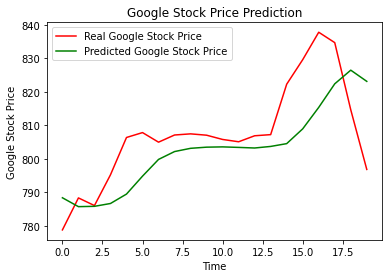

In [82]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()